# Warning
This notebook is under development- please use to evaluate entropy notebook and suggest desired changes only.

# Experiments on entropy

## Import libraries

In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import collections
from collections import namedtuple
import builtins
import math
import resurfemg.helper_functions as hf
# import our library
%matplotlib inline

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


In [2]:
# local resurf
# import our library
from config import Config
from tmsisdk_lite import Poly5Reader

# Set a collection place for experiments

In [3]:
# do not rerun this cell
big_data_list = []

Below change the path to the root directory where you are keeping your EMGs and ventilator "Draeger" files

# Reruns should be done from this cell as the start

In [4]:
config = Config()
root_emg_directory = config.get_directory('root_emg_directory')

In [5]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []

for file in emg_and_vent_files:
    if 'Draeger' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)

Now you can pick a file from the list, which have been numbered.

In [6]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

# Caution! 
If you folder is set up in any way different then the picked file numbers will not neccesarily correspond to the same file. Always check the print out for the file you have chosen in the cell below

In [7]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen] 
print("The file you chose is:",file_chosen)

The file you chose is: C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\M001\001\EMG_recording.Poly5


In [8]:
data_emg = Poly5Reader(file_chosen)
data_samples= data_emg.samples
emg_fs = data_emg.sample_rate
converted_to_seconds =  []
converted_to_samples = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_fs)
    converted_to_samples.append(i)

Reading file C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\M001\001\EMG_recording.Poly5
	 Number of samples:  172576 
	 Number of channels:  3 
	 Sample rate: 2048 Hz

Progress:  0.0 %

Progress:  1.6 %

Progress:  3.1 %

Progress:  4.7 %

Progress:  6.2 %

Progress:  7.8 %

Progress:  9.4 %

Progress:  10.9 %

Progress:  12.5 %

Progress:  14.1 %

Progress:  15.6 %

Progress:  17.2 %

Progress:  18.8 %

Progress:  20.3 %

Progress:  21.9 %

Progress:  23.4 %

Progress:  25.0 %

Progress:  26.6 %

Progress:  28.1 %

Progress:  29.7 %

Progress:  31.2 %

Progress:  32.8 %

Progress:  34.4 %

Progress:  35.9 %

Progress:  37.5 %

Progress:  39.1 %

Progress:  40.6 %

Progress:  42.2 %

Progress:  43.8 %

Progress:  45.3 %

Progress:  46.9 %

Progress:  48.4 %

Progress:  50.0 %

Progress:  51.6 %

Progress:  53.1 %

Progress:  54.7 %

Progress:  56.2 %

Progress:  57.8 %

Progress:  59.4 %

Progress:  60.9 %

Progress:  62.5 %

Progress:  64.1 %

Progress:  65.6 %

Progress:  

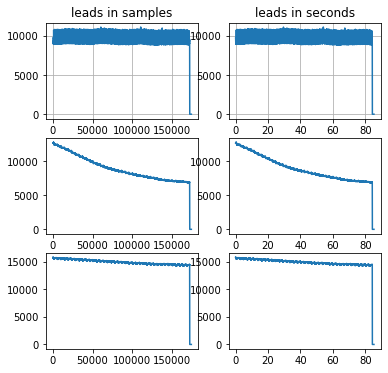

In [9]:
%matplotlib inline
# set up plotn
x = data_samples
fig, axis = plt.subplots(nrows = 3, ncols = 2, figsize=(6, 6))
#ax.set_ylim([-4, 4])
axis[0,0].grid(True)
axis[0,0].plot(x[0])
axis[0,0].set(title='leads in samples')
axis[1,0].plot(x[1])
axis[2,0].plot(x[2])
axis[0,1].set(title='leads in seconds')
axis[0,1].grid(True)
axis[0,1].plot(converted_to_seconds,x[0])
axis[1,1].plot(converted_to_seconds,x[1])
axis[2,1].plot(converted_to_seconds,x[2])

That is the whole unfiltered EMG, but you probably want to examine a part. You will also want to examine something filtered down to only the EMG components. Therefore we will filter off only the EMG components with an ICA in addtion to the filter we will play with.

Now you can filter down to which part you want to see. 

Do you want to cut and see the file in samples or seconds?

In [10]:
y_axis = widgets.Dropdown(
    options=["Samples","Seconds"],
    value='Samples',
    description="Select View Option",
    disabled=False,
)
display(y_axis)


Dropdown(description='Select View Option', options=('Samples', 'Seconds'), value='Samples')

In [11]:
time_view= y_axis.value
time_view

'Samples'

Now you will pick the start and end of your sample.We are going to clip the end of the sample in processing, so you can not pick any values and get a good graph. We preset the values towards the max graphable with ease, but they can be overwritten.  In the future we will have an updating graph here. 

In [12]:
if time_view == 'Samples':
    int_slider1 = widgets.IntSlider(
        min=0, max=int(len(x[0])*0.89), step=1,
        description=' samples start'
    )
    int_slider2 = widgets.IntSlider(
        value=len(x[0]),
        min=0, max=int(len(x[0])*0.89), step=1,
        description='samples end cutoff'
    )
else:
    int_slider1 = widgets.IntSlider(
        #value=0.1,
        min=0, max= int(converted_to_seconds[-1])*0.89, step=1,
        description='seconds start'
    )
    int_slider2 = widgets.IntSlider(
        #value=converted_to_seconds[-1],
        min=0, max=int(converted_to_seconds[-1])*0.89, step= 1,
        description='seconds end cutoff'
    )
    
widgets.VBox(
    [

        int_slider1,
        int_slider2,

    ]
)



You can overwrite the values by hand in the next cell, if scrolling is not precise enough...but rewriting to take an absolute end is unadvisable.

In [13]:
# # # # Here we can overwrite the values by hand, again you must pick values a bit inside
# int_slider1.value = 1
# int_slider2.value = 17

For now we will graph your choice in the next active cell

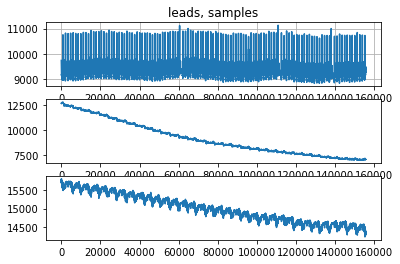

In [14]:
start = int_slider1.value
end= int_slider2.value
if time_view == 'Samples':
    # nox examine at a certain scale- from point a to b as samples
    x = data_samples
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(x[0][int(start):int(end)])
    ax_1.set(title='leads, samples')
    ax_2.plot(x[1][int(start):int(end)])
    ax_3.plot(x[2][int(start):int(end)])
    
if time_view == 'Seconds':
    # nox examine at a certain scale- from point a to b as samples
    x_for_secs = data_samples

    y = converted_to_seconds
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(y[int(start*emg_fs):int(end*emg_fs)],x[0][int(start*emg_fs):int(end*emg_fs)])
    ax_1.set(title='leads, seconds')
    ax_2.plot(y[int(start*emg_fs):int(end*emg_fs)],x[1][int(start*emg_fs):int(end*emg_fs)])
    ax_3.plot(y[int(start*emg_fs):int(end*emg_fs)],x[2][int(start*emg_fs):int(end*emg_fs)])
    

Happy with your selection? If not redo the widgeted cell, then we can see how the filter the selection in a basic pipleline before extracting entropy.

In [15]:
# dropdown to pick ICA possibilities. CUrrently only one -\o/-
ICA_choice = widgets.Dropdown(
    options=["classic","no_ica_lead3"],
    value='classic',
    description="Select View Option",
    disabled=False,
)
display(ICA_choice)

Dropdown(description='Select View Option', options=('classic', 'no_ica_lead3'), value='classic')

Here we will have to rewrite to accomodate different ICAs, but this is in the future. After we iron out the alternative ICAs. Below we put our EMG data through the pipeline we have now, and we must do picking from an ICA by more peaks or by dis-similarity to the heart/ECG lead.

In [16]:
ICA_picker_choice = widgets.Dropdown(
    options=["more_peaks","similar_to_ECG"],
    value='more_peaks',
    description="Select View Option",
    disabled=False,
)
display(ICA_picker_choice)

Dropdown(description='Select View Option', options=('more_peaks', 'similar_to_ECG'), value='more_peaks')

In [17]:
ICA_picker_choice.value

'more_peaks'

In [18]:
def working_pipeline_pre_entropy_peaks(our_chosen_samples): 
    cut_file_data = hf.bad_end_cutter_for_samples(our_chosen_samples, percent_to_cut=3, tolerance_percent=5)
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(cut_file_data, 5, 450, 2048, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the picking step!
    emg= hf.pick_more_peaks_array(components)
    # now process it in final steps
    abs_values = abs(emg)
    final_envelope_d = hf.emg_highpass_butter(abs_values, 150, 2048)
    
        
    return final_envelope_d

def working_pipeline_pre_entropy_ecg(our_chosen_samples): 
    cut_file_data = hf.bad_end_cutter_for_samples(our_chosen_samples, percent_to_cut=3, tolerance_percent=5)
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(cut_file_data, 5, 450, 2048, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the picking step!
    emg= hf.pick_lowest_correlation_array(components,re_cut_file_data[0] )
    # now process it in final steps
    abs_values = abs(emg)
    final_envelope_d = hf.emg_highpass_butter(abs_values, 150, 2048)
    
        
    return final_envelope_d

# Let's examine our processed EMG

C:\Users\makeda\anaconda3\envs\emgandash\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


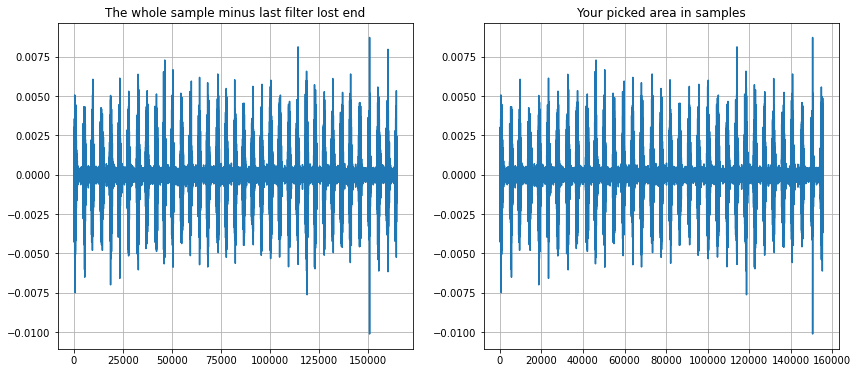

In [19]:
if ICA_picker_choice.value == 'more_peaks':
    processed_data_emg = working_pipeline_pre_entropy_peaks(data_samples)
elif ICA_picker_choice.value == 'similar_to_ECG':
    processed_data_emg = working_pipeline_pre_entropy_ecg(data_samples)
else:
    processed_data_emg = working_pipeline_pre_entropy_ecg(data_samples)

if time_view == 'Seconds':
    # set up plotn
    x = processed_data_emg
    fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
    axis[0].grid(True)
    axis[0].plot(converted_to_seconds[:len(x)], x)
    axis[0].set(title='The whole sample minus last filter lost end')
    axis[1].set(title='Your picked area in seconds')
    axis[1].grid(True)
    axis[1].plot(converted_to_seconds[int(start*emg_fs):int(end*emg_fs)],x[int(start*emg_fs):int(end*emg_fs)])
else:
    x = processed_data_emg
    fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 6))
    axis[0].grid(True)
    axis[0].plot(x)
    axis[0].set(title='The whole sample minus last filter lost end')
    axis[1].set(title='Your picked area in samples')
    axis[1].grid(True)
    axis[1].plot(converted_to_samples[int(start):int(end)],x[int(start):int(end)])
    

Now we created some basic processed EMG. We will graph it based on the sample selected and the cutoff on entropy. We will ultimately do a cut-off based on something popular in the literature, but let's do one based on one simple parameter first, as an example


In [20]:
# Now we want to select where the cut_off is

entropy_cutoff = widgets.Dropdown(
    options=["Mean","Half_range"],
    value='Mean',
    description="Select Entropy Cut off",
    disabled=False,
)
display(entropy_cutoff)


Dropdown(description='Select Entropy Cut off', options=('Mean', 'Half_range'), value='Mean')

In [21]:
def rounded_for_ent(stralist):
    rounded= np.round_(stralist, decimals = 5)
    return rounded
start_idx= start * emg_fs
end_idx = end * emg_fs
if time_view == 'Samples':
    big_list = rounded_for_ent(processed_data_emg[int(start):int(end)])# replace with whole array of time series!
else:
   
    big_list = rounded_for_ent(processed_data_emg[int(start_idx):int(end_idx)])
slice_length = 100
def sliceIterator(lst, sliceLen):
    for i in range(len(lst) - sliceLen + 1):
        yield lst[i:i + sliceLen]
index_hold = []
for slice in sliceIterator(big_list, slice_length):
    entropy_index = hf.entropical(slice)
    index_hold.append(entropy_index)

if entropy_cutoff.value == 'Half_range':
    decision_cutoff = (np.max(index_hold) + np.min(index_hold))/2
else:# entropy_cutoff.value == 'Mean':
    decision_cutoff = np.mean(index_hold)


rms_rolled = hf.vect_naive_rolling_rms(index_hold,100) # so rms is rms entropy

Now let's see how we would have split it on that criteria

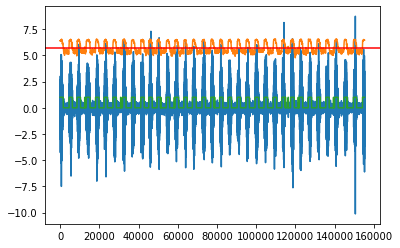

In [22]:
if time_view == 'Samples':
    #y= converted_to_samples
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],rms_rolled)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    
else:
    y = converted_to_seconds
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx)+int(len(rms_rolled)))], processed_data_emg[int(start_idx):(int(start_idx)+len(rms_rolled))]*1000)
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx)+int(len(rms_rolled)))],rms_rolled)
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    

In the above picture the green line represents a 0,1, array which represents the breaths. That picking was based on one simple parameter.

# Changes here!
Instead of above code we will do
pick breath based on 90% entropy
then 50%- this will give start of breath
define peak value within 90%
moving forward to right 70%-> with smoothing away if there is too short a pause. This is a more complicated algorithm. 

In [23]:
# reminder
time_view

'Samples'

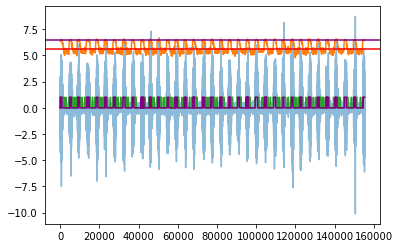

In [24]:

def rounded_for_ent(stralist):
    rounded= np.round_(stralist, decimals = 5)
    return rounded
if time_view == 'Samples':
    big_list = rounded_for_ent(processed_data_emg[int(start):int(end)])# replace with whole array of time series!
else:
    big_list = rounded_for_ent(processed_data_emg[int(start_idx):int(end_idx)])
slice_length = 100
def sliceIterator(lst, sliceLen):
    for i in range(len(lst) - sliceLen + 1):
        yield lst[i:i + sliceLen]
index_hold = []
for slice in sliceIterator(big_list, slice_length):
    entropy_index = hf.entropical(slice)
    index_hold.append(entropy_index)

high_decision_cutoff = 0.9  * ((np.max(index_hold)) - (np.min(index_hold))) + np.min(index_hold)
decision_cutoff = 0.5 * ((np.max(index_hold)) - (np.min(index_hold))) + np.min(index_hold)

rms_rolled = hf.vect_naive_rolling_rms(index_hold,100) # so rms is rms entropy


if time_view == 'Samples':
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],rms_rolled)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff), color= 'purple')
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    plt.axhline(y = high_decision_cutoff, color = 'purple', linestyle = '-')
    
else:
    y = converted_to_seconds
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx)+int(len(rms_rolled)))], processed_data_emg[int(start_idx):(int(start_idx)+len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx)+int(len(rms_rolled)))],rms_rolled)
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx)+int(len(rms_rolled)))],hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff), color = 'purple')
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    plt.axhline(y = high_decision_cutoff, color = 'purple', linestyle = '-')
    

In [25]:
def merge(left, right):
    # Initialize an empty list output that will be populated with sorted elements.
    # Initialize two variables i and j which are used pointers when iterating through the lists.
    output = []
    i = j = 0

    # Executes the while loop if both pointers i and j are less than the length of the left and right lists
    while i < len(left) and j < len(right):
        # Compare the elements at every position of both lists during each iteration
        if left[i] < right[j]:
            # output is populated with the lesser value
            output.append(left[i])
            # 10. Move pointer to the right
            i += 1
        else:
            output.append(right[j])
            j += 1
    # The remnant elements are picked from the current pointer value to the end of the respective list
    output.extend(left[i:])
    output.extend(right[j:])

    return output

In [26]:


slice = builtins.slice

class Range(namedtuple('RangeBase', 'start,end')):
    
    def intersects(self, other):
        return (
            (self.end >= other.end) and (self.start < other.end) or
            (self.end >= other.start) and (self.start < other.start) or
            (self.end < other.end) and (self.start >= other.start)
        )
    
    def precedes(self, other):
        return self.end < other.start
    
    def to_slice(self):
        return slice(*map(int, self)) # maps whole tuple set
    


def ranges_of(array):
    marks = np.logical_xor(array[1:], array[:-1])
    boundaries = np.hstack((np.zeros(1), np.where(marks != 0)[0], np.zeros(1) + len(array) - 1))

    if not array[0]:
        boundaries = boundaries[1:]
    if len(boundaries) % 2 != 0:
        boundaries = boundaries[:-1]
    return tuple(Range(*boundaries[i:i+2]) for i in range(0, len(boundaries), 2))


def intersections(left, right):
    i, j = 0, 0
    result = []
    while i < len(left) and j < len(right):
        lelt, relt = left[i], right[j]
        if lelt.intersects(relt):
            result.append(lelt)
            i += 1
        elif relt.precedes(lelt):
            j += 1
        elif lelt.precedes(relt):
            i += 1
    return result


hi = np.array(hf.zero_one_for_jumps_base(rms_rolled, high_decision_cutoff))
lo = np.array(hf.zero_one_for_jumps_base(rms_rolled, decision_cutoff))

rhi = ranges_of(hi)
rlo = ranges_of(lo)

keep = intersections(rlo, rhi)


points = np.array(sum(keep, start=()), dtype=np.int32)
points

array([     0,   1652,   4515,   6224,   8558,  10395,  13216,  15237,
        17997,  19831,  22360,  24189,  26891,  28723,  31758,  33625,
        36326,  38137,  41115,  42938,  45156,  46989,  49410,  51106,
        54114,  55917,  58524,  60437,  63055,  64825,  67422,  69669,
        72356,  74185,  76776,  78692,  81315,  83012,  85673,  87371,
        90289,  91998,  94765,  96576,  99383, 101367, 103997, 105871,
       108659, 110679, 113110, 115124, 117515, 119428, 121976, 123769,
       126541, 128294, 130958, 132610, 135510, 137390, 139975, 141834,
       144777, 146544, 149564, 151291, 154212, 155300])

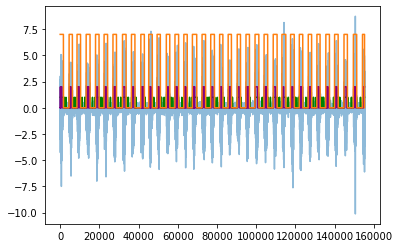

In [27]:
seven_line = np.zeros(len(rms_rolled))
for seven_range in keep:
    seven_line[seven_range.to_slice()] = 7
if time_view == 'Samples':
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],processed_data_emg[int(start):(int(start) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff),  color = 'green')
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))],(np.array(hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff)))*2, color= 'purple')
    #plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))], six_line)
    plt.plot(converted_to_samples[int(start):(int(start) + len(rms_rolled))], seven_line)
else:
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx) + len(rms_rolled))],processed_data_emg[int(start_idx):(int(start_idx) + len(rms_rolled))]*1000, alpha = 0.5)
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx) + len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff),  color = 'green')
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx) + len(rms_rolled))],(np.array(hf.zero_one_for_jumps_base(rms_rolled,high_decision_cutoff)))*2, color= 'purple')
    #plt.plot(converted_tosecondss[int(star_st):(int(star_st) + len(rms_rolled))], six_line)
    plt.plot(converted_to_seconds[int(start_idx):(int(start_idx) + len(rms_rolled))], seven_line)
    

So above our 'seven-line' represents picking based on finding areas with 90% max entropy, then picking evything around them with over 50% entropy.

## What happened in these breaths?

We want to know the area under the curve for each breath- then the area to where we cross back over 70% of peak values- but should we look at entropy directly- question for Eline. Let's start with breaking the segments into breath or not breath segments.

In [28]:
# our_emg_array = processed_data_emg[int(start):(int(start) + len(rms_rolled))]
# jump_indeces = []
# zippy = zip(seven_line,seven_line[1:])
# for val in enumerate(zippy):
#     if val[1][0] != val[1][1]:
#         print(val[0])
#         jump_indeces.append(val[0])

# grouped = np.split(our_emg_array, jump_indeces)
# grouped

Now we need to figure out which elements of grouped are breath parts, and make arrays of just those.

In [29]:
# so grouped needs to be picked down to where at jump indeces we go up from 0 to 7
our_emg_array_samples = processed_data_emg[int(start):(int(start) + len(rms_rolled))]
our_emg_array_seconds = processed_data_emg[int(start_idx):(int(start_idx) + len(rms_rolled))]
zippy = zip(seven_line,seven_line[1:])
breath_indeces = []
for val in enumerate(zippy):
    if val[1][0] < val[1][1]:
        print(val[0])
        breath_indeces.append(val[0])
if time_view == 'Samples':
    grouped_breaths = np.split(our_emg_array_samples, breath_indeces)
    grouped_entropy= np.split(rms_rolled, breath_indeces)

else:
    grouped_breaths = np.split(our_emg_array_seconds, breath_indeces)
    grouped_entropy= np.split(rms_rolled, breath_indeces)

4514
8557
13215
17996
22359
26890
31757
36325
41114
45155
49409
54113
58523
63054
67421
72355
76775
81314
85672
90288
94764
99382
103996
108658
113109
117514
121975
126540
130957
135509
139974
144776
149563
154211


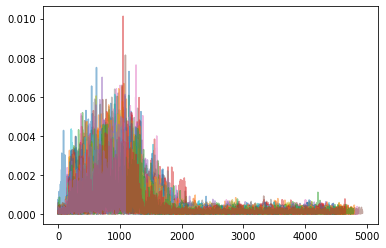

In [30]:
for group in grouped_breaths:
    group = abs(group)
    plt.plot(group, alpha = 0.5)

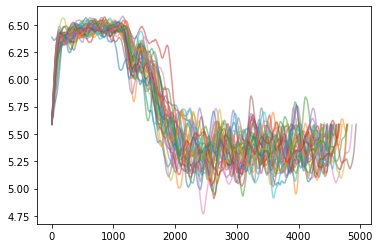

In [31]:
for group in grouped_entropy:
     plt.plot(group, alpha = 0.5)

# now for each breath started segment get the absolute value, smooth it, and get the area under the curve until we reach 70%
The first cell below is an examiner where we plot out the absolute value on each breath group to make sure we are catching breaths.

Now we will plot out the smoothed breaths:

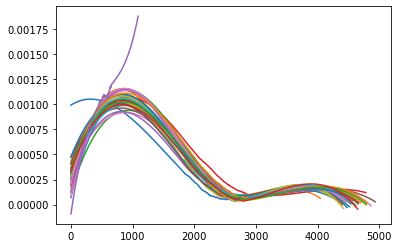

In [32]:
smoothed_breaths = []
for group in grouped_breaths:
    group = abs(group)
    smoothed = savgol_filter(group, int(0.8* (len(group))), 3)
    plt.plot(smoothed)
    smoothed_breaths.append(smoothed)

Now we will plot out smoothed entropy

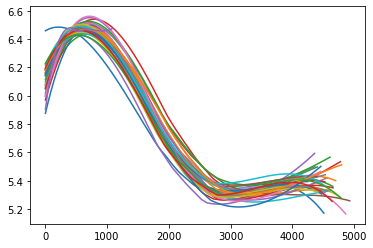

In [33]:
smoothed_breaths_entropy = []
for group in grouped_entropy:
    smoothed = savgol_filter(group, int(0.8* (len(group))), 3)
    plt.plot(smoothed)
    smoothed_breaths_entropy.append(smoothed)

Now we will calculate the area under the curve until the curve of the breath passes it's maximum then hits 70% of it's peak value. 

In [34]:
curve_area_under = []
for curve in smoothed_breaths:
    max_ind = (curve.argmax())
    max_val = curve[max_ind]
    absolute_val_array = np.abs(curve[max_ind:] - curve.max() * 0.7)
    smallest_difference_index = absolute_val_array.argmin()
    closest_element = curve[max_ind:][smallest_difference_index]
    smallest_difference_index = smallest_difference_index + max_ind
    area_under_curve_cut = curve[:smallest_difference_index].sum()
    curve_area_under.append(area_under_curve_cut)
    

    

In [35]:
# the future function pending eline approval 
def breath_curve_catch(curve):
    """
    The function is intended for smoothed arrays
    The function takes a smoothed breath array then calculates part of the area under the curve 
    including up to the peak and then to 70% of the peak valye
    """
    max_ind = (curve.argmax())
    max_val = curve[max_ind]
    absolute_val_array = np.abs(curve[max_ind:] - curve.max() * 0.7)
    smallest_difference_index = absolute_val_array.argmin()
    closest_element = curve[max_ind:][smallest_difference_index]
    smallest_difference_index = smallest_difference_index + max_ind
    area_under_curve_cut = curve[:smallest_difference_index].sum()
    return area_under_curve_cut

In [36]:
# so now we have an array with all of those areas (to 70% of curve ) for each smoothed breath
curve_area_under

[1.151775245171763,
 1.3239184835505124,
 1.2305515000655858,
 1.4691861505296828,
 1.390638458790047,
 1.288788069296473,
 1.2676908372508144,
 1.4816477587856007,
 1.3668217067737292,
 1.306410646840269,
 1.2797368170451109,
 1.3411531068249658,
 1.3106641457708048,
 1.3289921415982828,
 1.1451124853291061,
 1.3422058359342384,
 1.4022194756608757,
 1.3892073988930351,
 1.2633503429762425,
 1.2923348474630427,
 1.2820744634087475,
 1.3886618212127009,
 1.513456998670351,
 1.3638068154538106,
 1.4443892175242148,
 1.2605107351075926,
 1.4583168113828178,
 1.3988512025592603,
 1.3519352098737643,
 1.362790479618503,
 1.3935520364545817,
 1.499870137590136,
 1.3685696973763366,
 1.2962362461637262,
 1.1047993083685896]

OK, but what area these areas? let's see an example of what curve it cuts then takes the area under

In [37]:
list_of_numbers_to_show = []
for i in range(len(smoothed_breaths)):
    list_of_numbers_to_show.append(str(i))


breath_to_show = widgets.Dropdown(
    options=list_of_numbers_to_show,
    value='1',
    description='Picked Breaths:',
    disabled=False,
)
display(breath_to_show)

Dropdown(description='Picked Breaths:', index=1, options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '1…

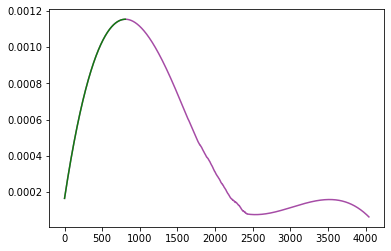

In [38]:
# let's show an example with a graph to show how it looks
curve_example = smoothed_breaths[int(breath_to_show.value)]
max_ind = (curve_example.argmax())
max_val =  curve_example[max_ind]
absolute_val_array = np.abs(curve_example[max_ind:] - curve.max() * 0.7)
smallest_difference_index = absolute_val_array.argmin()
closest_element = curve_example[max_ind:][smallest_difference_index]
smallest_difference_index = smallest_difference_index + max_ind
area_under_curve_cut = curve_example[:smallest_difference_index].sum()
plt.plot(curve_example, color= 'purple', alpha = 0.7)
plt.plot(curve_example[:smallest_difference_index],color = 'green', alpha = 0.9)

## But what if we want to cut on 70% entropy past the peak instead?

In [39]:
curve_area_under_entropy = []

for i, entropy_curve in enumerate(smoothed_breaths_entropy):
    max_ind = (entropy_curve.argmax())
    max_val = entropy_curve[max_ind]
    absolute_val_array = np.abs(entropy_curve[max_ind:] - entropy_curve.max() * 0.7)
    smallest_difference_index = absolute_val_array.argmin()
    closest_element = entropy_curve[max_ind:][smallest_difference_index]
    smallest_difference_index = smallest_difference_index + max_ind
    area_under_curve_cut = smoothed_breaths[i][:smallest_difference_index].sum()
    curve_area_under_entropy.append(area_under_curve_cut)

In [40]:
curve_area_under_entropy

[1.828267386840051,
 1.767088984571422,
 1.599568034872905,
 1.948770584757177,
 1.8296754099623462,
 1.6781256467758772,
 1.866484593219321,
 1.9755271260692595,
 1.756454588738354,
 1.7817503186765435,
 1.6980406081293888,
 1.7250290707285578,
 1.706287130557206,
 1.7200912157118253,
 1.4823604983948269,
 1.9669827399611202,
 1.8264928658303337,
 1.827724500984221,
 1.6427381350865025,
 1.7128791390374973,
 1.883423457279555,
 1.829077914074503,
 1.9930475025562917,
 1.7647433293253303,
 1.9141603522551467,
 1.6634700374458973,
 1.9075280783377258,
 1.8225182091006413,
 1.7525834346827986,
 1.9967238268226506,
 1.8215887889867708,
 1.9475326781538413,
 1.9782925847228885,
 1.9020141685632348,
 0.31946818268136]

In [41]:
our_emg_array = processed_data_emg[int(start):(int(start) + len(rms_rolled))]
our_entropy_array = rms_rolled
zippy = zip(seven_line,seven_line[1:])
breath_indeces = []
for val in enumerate(zippy):
    if val[1][0] < val[1][1]:
        print(val[0])
        breath_indeces.append(val[0])

grouped_breaths = np.split(our_emg_array, breath_indeces)
grouped_entropy= np.split(rms_rolled, breath_indeces)
grouped_entropy

4514
8557
13215
17996
22359
26890
31757
36325
41114
45155
49409
54113
58523
63054
67421
72355
76775
81314
85672
90288
94764
99382
103996
108658
113109
117514
121975
126540
130957
135509
139974
144776
149563
154211


[array([6.38543586, 6.38401658, 6.38279797, ..., 5.57066365, 5.57744593,
        5.58394912]),
 array([5.59076327, 5.59752119, 5.60446602, ..., 5.56410695, 5.57310483,
        5.58197542]),
 array([5.59025468, 5.59869163, 5.6069762 , ..., 5.5779637 , 5.58286241,
        5.58829247]),
 array([5.59436842, 5.60012024, 5.60584789, ..., 5.55872456, 5.56876615,
        5.5789645 ]),
 array([5.58936921, 5.59973238, 5.61032008, ..., 5.58518132, 5.58943928,
        5.59401317]),
 array([5.59820192, 5.60267228, 5.60740755, ..., 5.57139278, 5.57868327,
        5.58613207]),
 array([5.59379544, 5.60152833, 5.6094311 , ..., 5.56637625, 5.57411661,
        5.58206591]),
 array([5.59007638, 5.59845054, 5.6066208 , ..., 5.58232419, 5.58648791,
        5.59093537]),
 array([5.59583049, 5.60099018, 5.60587651, ..., 5.56269162, 5.57129891,
        5.5799753 ]),
 array([5.58889578, 5.59802008, 5.60740473, ..., 5.57342605, 5.58010452,
        5.58698249]),
 array([5.59387849, 5.60081061, 5.60737849, ..., 5

## So great, we can do it, however we have to agree that the amount of smoothing to calculate these things is acceptable, and whether we use the entropy or the EMG itself

## We also need to agree on what other data is collected into the final spreadsheet

First we can compare counted 'breaths' to algorithm breaths, then we can compare a sequence of peaks.

In [42]:
my_count = input()

10


Now let's compare our peak value sequence



Also we are looking at distance from zero to positive maxima, but the amplitude would be from adjancent low value...
We can look at an absolute value array?

In [43]:
def find_maxima_in_high_entropy_area(our_array,start=0, end=10000, decision_cutoff='mean'):
    """
    Finds maxima in high entropy areas. You need to have made an rms_rolled variable
    on the entropy areas.
    The function is not yet optimized, but works here in the notebook. 
    """
 
    #rms_rolled= 
    decision_array = hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff)
    if decision_array[0] == 1:
        ups_and_downs = np.logical_xor(decision_array[1:], decision_array[:-1])
        indeces_of_boundaries = np.where(ups_and_downs)[0]
        maxima = []
        boundaries = np.append(
            np.append(np.zeros(1), indeces_of_boundaries),
            np.zeros(1) + len(our_array),
        )
        # print(boundaries)
        boundaries = boundaries.astype(np.int32)
        for slice_start, slice_end in zip(boundaries[::2], boundaries[1::2]):
            #print(slice_start, slice_end)
            beat = our_array[slice_start:slice_end]
            maxima.append(slice_start + np.where(beat == beat.max())[0][0])
        maxima_values = our_array[maxima]
        # print(maxima_values)
        rep_array = np.zeros(len(our_array))
        rep_array[maxima] = np.mean(maxima_values)
        plt.plot(our_array, alpha = 0.7)
        plt.plot(rep_array, alpha = 0.4)
    else: 
        ups_and_downs = np.logical_xor(decision_array[1:], decision_array[:-1])
        indeces_of_boundaries = np.where(ups_and_downs)[0]
        maxima = []
        boundaries = np.append(
            indeces_of_boundaries,
            np.zeros(1) + len(our_array),
        )
        boundaries = boundaries.astype(np.int32)
        for slice_start, slice_end in zip(boundaries[::2], boundaries[1::2]):
            #print(slice_start, slice_end)
            beat = our_array[slice_start:slice_end]
            maxima.append(slice_start + np.where(beat == beat.max())[0][0])
        maxima_values = our_array[maxima]
        #print(maxima_values)
        rep_array = np.zeros(len(our_array))
        rep_array[maxima] = np.mean(maxima_values)
        plt.plot(our_array, alpha = 0.7)
        plt.plot(rep_array, alpha = 0.4)
    return maxima, maxima_values
        

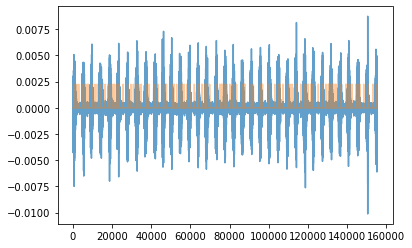

In [44]:
if time_view == 'Samples':
    our_array = processed_data_emg[int(start):int(end)]
    starter=int(start)
    ender= int(end)
else: 
    our_array = processed_data_emg[int(start_idx):int(end_idx)]
    starter=int(start_idx)
    ender= int(end_idx)

maximal , maximal_values = find_maxima_in_high_entropy_area(our_array,start=starter, end=ender, decision_cutoff=decision_cutoff)
# note the x axis will be from zero counting up but represent the difference

There are several decisions that need to be made here. Note the following:
    
    We are looking at maxima on the positive. Maybe we should be looking on both sides of zero? Maybe we should be lokking at an absolute value, and then find the maxima? Also note our cut-off on entropy was a bit arbitraty, and gave us an extra breath. These are decisions for the scientific side of a team that need to happen before this interface can go furhter.  

Then we have to decide if we do area under curve for the absolute value, or what?

Now I can save off the info on this run:

In [48]:
data_now = [file_chosen, number_chosen, time_view, start, end, my_count, maximal, maximal_values, curve_area_under]

In [49]:
data_now

['C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\\M001\\001\\EMG_recording.Poly5',
 0,
 'Samples',
 0,
 155500,
 '10',
 [453,
  2054,
  2958,
  5160,
  6364,
  7289,
  8010,
  9700,
  11230,
  12459,
  13854,
  16480,
  17779,
  18706,
  20423,
  21203,
  22258,
  23395,
  25623,
  27962,
  29574,
  30907,
  32673,
  33945,
  34774,
  37375,
  38178,
  38716,
  42074,
  43383,
  46304,
  47759,
  50473,
  51334,
  51718,
  52996,
  54508,
  56042,
  56925,
  58271,
  59834,
  62052,
  64027,
  66001,
  67267,
  68142,
  69841,
  73298,
  75000,
  75806,
  76278,
  77596,
  78788,
  80126,
  81928,
  83582,
  86651,
  87597,
  87900,
  91208,
  92197,
  95806,
  96585,
  96842,
  100343,
  103097,
  105190,
  105893,
  107211,
  109849,
  110954,
  111943,
  114199,
  116399,
  118517,
  119742,
  120208,
  121473,
  122564,
  125388,
  127550,
  129261,
  130545,
  131874,
  132652,
  132800,
  133185,
  133932,
  134411,
  136851,
  139506,
  140956,
  142095,
  142666,
  14

In [50]:
big_data_list.append(data_now)
big_data_list

[['C:/Projects/ReSurfEMG/not_pushed/topspin_data_anonymized\\M001\\001\\EMG_recording.Poly5',
  0,
  'Samples',
  0,
  155500,
  '10',
  [453,
   2054,
   2958,
   5160,
   6364,
   7289,
   8010,
   9700,
   11230,
   12459,
   13854,
   16480,
   17779,
   18706,
   20423,
   21203,
   22258,
   23395,
   25623,
   27962,
   29574,
   30907,
   32673,
   33945,
   34774,
   37375,
   38178,
   38716,
   42074,
   43383,
   46304,
   47759,
   50473,
   51334,
   51718,
   52996,
   54508,
   56042,
   56925,
   58271,
   59834,
   62052,
   64027,
   66001,
   67267,
   68142,
   69841,
   73298,
   75000,
   75806,
   76278,
   77596,
   78788,
   80126,
   81928,
   83582,
   86651,
   87597,
   87900,
   91208,
   92197,
   95806,
   96585,
   96842,
   100343,
   103097,
   105190,
   105893,
   107211,
   109849,
   110954,
   111943,
   114199,
   116399,
   118517,
   119742,
   120208,
   121473,
   122564,
   125388,
   127550,
   129261,
   130545,
   131874,
   132652,
   

In [53]:
# data_now = [file_chosen, number_chosen, time_view, start, end, my_count, maximal, maximal_values, curve_area_under]
# columns_now = ['file_chosen',
#                'number_file',
#                'units',
#                'start_cut',
#                'end_cut',
#                'my_hand_count',
#                'automated_breath_count',
#                'maxima',
#                'maxima_values',
#                'curve_area_under',
#                'curve_area_under_entropy',
#                ]

columns_now = ['file_chosen',
               'number_file',
               'units',
               'start_cut',
               'end_cut',
               'my_hand_count',
               #'automated_breath_count',
               'maxima',
               'maxima_values',
               'curve_area_under',
               ]


df = pd.DataFrame(big_data_list, columns=columns_now)

In [54]:
df

,file_chosen,number_file,units,start_cut,end_cut,my_hand_count,maxima,maxima_values,curve_area_under
0,C:/Projects/ReSurfEMG/not_pushed/topspin_data_...,0,Samples,0,155500,10,"[453, 2054, 2958, 5160, 6364, 7289, 8010, 9700...","[0.005074303938223595, 0.00030814019748625406,...","[1.151775245171763, 1.3239184835505124, 1.2305..."


In [55]:
#You probably want to change the name to a timestamp, and save every hour, at least. 
df.to_csv('my_saved_entropy_experiments.csv')